## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from scipy import stats

# Configure plotting
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 3)

## Load Data

In [2]:
# Load pre-period features
features_df = pd.read_csv('../data/store_preperiod_features.csv')

# Load full sales data
df = pd.read_csv('../data/store_weekly_sales.csv')

print(f"Loaded features for {len(features_df)} stores")
print(f"Treatment stores: {features_df['treatment'].sum()}")
print(f"Control stores: {(1 - features_df['treatment']).sum()}")
print(f"\nFirst few rows:")
features_df.head()

Loaded features for 200 stores
Treatment stores: 50
Control stores: 150

First few rows:


,store_id,pre_slope,pre_avg_sales,pre_sales_std,pre_cv,treatment
0,STORE_001,209.985,94213.636,16504.675,0.175,0
1,STORE_002,9.046,93900.288,15237.331,0.162,1
2,STORE_003,1063.644,127332.277,25332.164,0.199,1
3,STORE_004,695.201,114587.751,20382.878,0.178,0
4,STORE_005,7.204,114378.208,14108.651,0.123,0


## Prepare Matching Features

We'll match on two key pre-period characteristics:
- **Slope**: Sales trend (growth/decline rate)
- **Average Sales**: Store size/scale

In [3]:
# Select features for matching
matching_features = ['pre_slope', 'pre_avg_sales']

# Separate treatment and control stores
treatment_stores = features_df[features_df['treatment'] == 1].copy()
control_stores = features_df[features_df['treatment'] == 0].copy()

print(f"Treatment stores: {len(treatment_stores)}")
print(f"Control stores: {len(control_stores)}")
print(f"\nFeatures used for matching:")
print(f"  - {matching_features[0]}: Sales slope (trend)")
print(f"  - {matching_features[1]}: Average sales (scale)")

Treatment stores: 50
Control stores: 150

Features used for matching:
  - pre_slope: Sales slope (trend)
  - pre_avg_sales: Average sales (scale)


## Standardize Features

Standardization ensures both features contribute equally to distance calculations.

In [4]:
# Standardize based on control stores only (to avoid data leakage)
scaler = StandardScaler()
scaler.fit(control_stores[matching_features])

# Transform both treatment and control
treatment_features_scaled = scaler.transform(treatment_stores[matching_features])
control_features_scaled = scaler.transform(control_stores[matching_features])

print("Standardized features:")
print(f"  Treatment shape: {treatment_features_scaled.shape}")
print(f"  Control shape: {control_features_scaled.shape}")
print(f"\nControl features - mean: {control_features_scaled.mean(axis=0)}")
print(f"Control features - std: {control_features_scaled.std(axis=0)}")

Standardized features:
  Treatment shape: (50, 2)
  Control shape: (150, 2)

Control features - mean: [-2.36847579e-17 -3.31586610e-16]
Control features - std: [1. 1.]


In [ ]:
# Plot distributions before matching
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pre-slope distribution
ax = axes[0, 0]
ax.hist(treatment_stores['pre_slope'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(control_stores['pre_slope'], bins=20, alpha=0.6, label='Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_slope'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(control_stores['pre_slope'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Slope ($/week)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('BEFORE Matching: Sales Slope Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, f"SMD = {smd_before['pre_slope']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 2: Pre-avg_sales distribution
ax = axes[0, 1]
ax.hist(treatment_stores['pre_avg_sales'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(control_stores['pre_avg_sales'], bins=20, alpha=0.6, label='Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_avg_sales'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(control_stores['pre_avg_sales'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Average Sales ($)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('BEFORE Matching: Average Sales Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.text(0.05, 0.95, f"SMD = {smd_before['pre_avg_sales']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 3: Pre-sales_std distribution
ax = axes[1, 0]
ax.hist(treatment_stores['pre_sales_std'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(control_stores['pre_sales_std'], bins=20, alpha=0.6, label='Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_sales_std'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(control_stores['pre_sales_std'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Sales Volatility ($)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('BEFORE Matching: Sales Volatility Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.text(0.05, 0.95, f"SMD = {smd_before['pre_sales_std']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Plot 4: Summary statistics table
ax = axes[1, 1]
ax.axis('off')
summary_data = []
for feature in ['pre_slope', 'pre_avg_sales', 'pre_sales_std']:
    summary_data.append([
        feature.replace('pre_', '').replace('_', ' ').title(),
        f"{treatment_stores[feature].mean():.2f}",
        f"{control_stores[feature].mean():.2f}",
        f"{smd_before[feature]:.3f}"
    ])

table = ax.table(cellText=summary_data,
                colLabels=['Feature', 'Treatment Mean', 'Control Mean', 'SMD'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Summary Statistics BEFORE Matching', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../reports/figures/balance_before_matching.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/balance_before_matching.png")

In [ ]:
def compute_standardized_mean_difference(treatment_vals, control_vals):
    """
    Compute standardized mean difference (SMD).
    SMD = (mean_treatment - mean_control) / pooled_std
    
    SMD < 0.1 is considered good balance
    SMD < 0.2 is acceptable
    SMD > 0.2 indicates imbalance
    """
    mean_t = np.mean(treatment_vals)
    mean_c = np.mean(control_vals)
    var_t = np.var(treatment_vals, ddof=1)
    var_c = np.var(control_vals, ddof=1)
    
    pooled_std = np.sqrt((var_t + var_c) / 2)
    
    if pooled_std == 0:
        return 0.0
    
    smd = (mean_t - mean_c) / pooled_std
    return smd

# Compute SMD before matching
print("Standardized Mean Differences (SMD) - BEFORE Matching")
print("="*70)
print(f"{'Feature':<25} {'SMD':>10} {'Balance Assessment':>25}")
print("-"*70)

smd_before = {}
for feature in ['pre_slope', 'pre_avg_sales', 'pre_sales_std']:
    treatment_vals = treatment_stores[feature].values
    control_vals = control_stores[feature].values
    
    smd = compute_standardized_mean_difference(treatment_vals, control_vals)
    smd_before[feature] = smd
    
    # Assess balance
    if abs(smd) < 0.1:
        assessment = "✓ Good"
    elif abs(smd) < 0.2:
        assessment = "~ Acceptable"
    else:
        assessment = "✗ Imbalanced"
    
    print(f"{feature:<25} {smd:>10.3f} {assessment:>25}")

print("\nNote: |SMD| < 0.1 = Good, < 0.2 = Acceptable, > 0.2 = Imbalanced")

## Pre-Matching Balance Assessment

Before matching, compare the distributions of key features between treatment and control stores.

## Implement Matching Algorithm

For each treatment store:
1. Find k=3 nearest control stores based on Euclidean distance
2. Match **without replacement** (each control used only once)
3. Use a greedy approach: match treatment stores in order of hardest-to-match first

In [5]:
def match_stores_without_replacement(treatment_features, control_features, 
                                     treatment_ids, control_ids, k=3):
    """
    Match treatment stores to control stores without replacement.
    
    Parameters:
    - treatment_features: standardized features for treatment stores (n_treatment x n_features)
    - control_features: standardized features for control stores (n_control x n_features)
    - treatment_ids: store IDs for treatment stores
    - control_ids: store IDs for control stores
    - k: number of control stores to match per treatment store
    
    Returns:
    - matches: dict mapping treatment_id -> list of matched control_ids
    - distances: dict mapping treatment_id -> list of distances to matches
    """
    # Build KNN model on all control stores
    nbrs = NearestNeighbors(n_neighbors=min(k*2, len(control_features)), 
                           metric='euclidean')
    nbrs.fit(control_features)
    
    # Find potential matches for each treatment store
    distances_all, indices_all = nbrs.kneighbors(treatment_features)
    
    # Order treatment stores by difficulty of matching (median distance to k neighbors)
    median_distances = np.median(distances_all[:, :k], axis=1)
    treatment_order = np.argsort(-median_distances)  # Descending order (hardest first)
    
    matches = {}
    match_distances = {}
    used_controls = set()
    
    # Match treatment stores in order
    for t_idx in treatment_order:
        treatment_id = treatment_ids.iloc[t_idx]
        
        # Get candidate controls (sorted by distance)
        candidate_indices = indices_all[t_idx]
        candidate_distances = distances_all[t_idx]
        
        # Select up to k controls that haven't been used
        matched_controls = []
        matched_distances = []
        
        for c_idx, dist in zip(candidate_indices, candidate_distances):
            control_id = control_ids.iloc[c_idx]
            
            if control_id not in used_controls:
                matched_controls.append(control_id)
                matched_distances.append(dist)
                used_controls.add(control_id)
                
                if len(matched_controls) == k:
                    break
        
        matches[treatment_id] = matched_controls
        match_distances[treatment_id] = matched_distances
    
    return matches, match_distances

# Apply matching
print("Matching treatment stores to controls...")
matches, match_distances = match_stores_without_replacement(
    treatment_features_scaled,
    control_features_scaled,
    treatment_stores['store_id'],
    control_stores['store_id'],
    k=3
)

print(f"\n✓ Matching complete!")
print(f"  Matched {len(matches)} treatment stores")

# Check match counts
match_counts = [len(v) for v in matches.values()]
print(f"\nMatches per treatment store:")
print(f"  Min: {min(match_counts)}")
print(f"  Max: {max(match_counts)}")
print(f"  Mean: {np.mean(match_counts):.2f}")

# Total unique controls used
unique_controls_used = set()
for controls in matches.values():
    unique_controls_used.update(controls)
print(f"\nUnique control stores used: {len(unique_controls_used)} out of {len(control_stores)}")

Matching treatment stores to controls...

✓ Matching complete!
  Matched 50 treatment stores

Matches per treatment store:
  Min: 0
  Max: 3
  Mean: 2.08

Unique control stores used: 104 out of 150


## Examine Match Quality

Check the distribution of distances to assess match quality.

Match Distance Statistics:
  Mean: 0.407
  Median: 0.285
  Std: 0.300
  Min: 0.035
  Max: 1.227


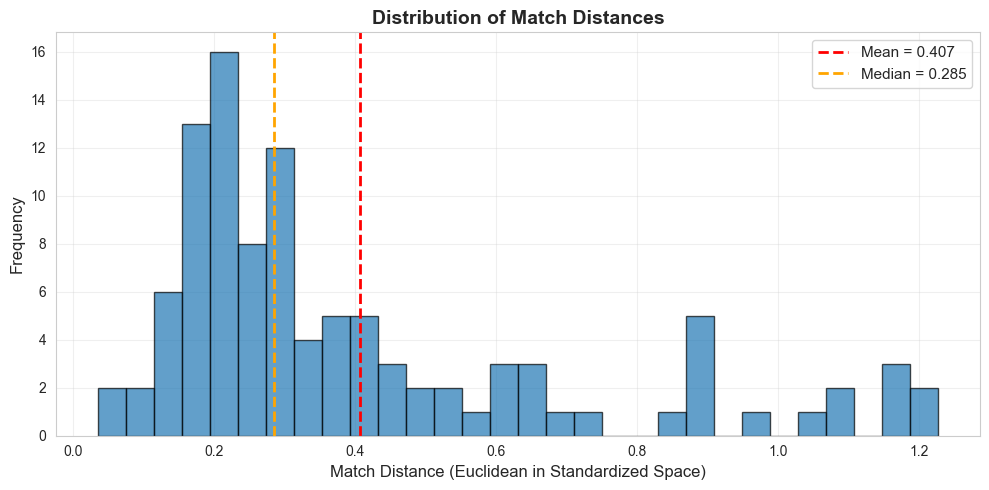


Note: Lower distances indicate better matches


In [6]:
# Flatten all distances
all_distances = []
for distances in match_distances.values():
    all_distances.extend(distances)

all_distances = np.array(all_distances)

print("Match Distance Statistics:")
print(f"  Mean: {all_distances.mean():.3f}")
print(f"  Median: {np.median(all_distances):.3f}")
print(f"  Std: {all_distances.std():.3f}")
print(f"  Min: {all_distances.min():.3f}")
print(f"  Max: {all_distances.max():.3f}")

# Plot distance distribution
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(all_distances, bins=30, edgecolor='black', alpha=0.7)
ax.axvline(all_distances.mean(), color='red', linestyle='--', 
           linewidth=2, label=f'Mean = {all_distances.mean():.3f}')
ax.axvline(np.median(all_distances), color='orange', linestyle='--', 
           linewidth=2, label=f'Median = {np.median(all_distances):.3f}')
ax.set_xlabel('Match Distance (Euclidean in Standardized Space)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Match Distances', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nNote: Lower distances indicate better matches")

## Create Matched Dataset

Build a dataset with treatment-control pairs for analysis.

In [7]:
# Create matched pairs dataset
matched_pairs = []

for treatment_id, control_ids in matches.items():
    distances = match_distances[treatment_id]
    
    for control_id, distance in zip(control_ids, distances):
        matched_pairs.append({
            'treatment_id': treatment_id,
            'control_id': control_id,
            'match_distance': distance
        })

matched_df = pd.DataFrame(matched_pairs)

# Add treatment store features
matched_df = matched_df.merge(
    features_df[['store_id', 'pre_slope', 'pre_avg_sales', 'pre_sales_std']],
    left_on='treatment_id',
    right_on='store_id',
    suffixes=('', '_treatment')
).drop('store_id', axis=1)

# Add control store features
matched_df = matched_df.merge(
    features_df[['store_id', 'pre_slope', 'pre_avg_sales', 'pre_sales_std']],
    left_on='control_id',
    right_on='store_id',
    suffixes=('_treatment', '_control')
).drop('store_id', axis=1)

print(f"Created {len(matched_df)} matched pairs")
print(f"\nFirst few matched pairs:")
matched_df.head(10)

Created 104 matched pairs

First few matched pairs:


,treatment_id,control_id,match_distance,pre_slope_treatment,pre_avg_sales_treatment,pre_sales_std_treatment,pre_slope_control,pre_avg_sales_control,pre_sales_std_control
0,STORE_099,STORE_084,0.879,-400.295,136948.361,21837.993,-129.448,136274.615,18482.905
1,STORE_099,STORE_138,0.906,-400.295,136948.361,21837.993,-508.027,118578.745,20121.059
2,STORE_099,STORE_122,0.983,-400.295,136948.361,21837.993,-98.712,139203.307,22806.512
3,STORE_132,STORE_076,1.066,-316.550,142335.848,19862.582,-151.073,122098.367,16096.079
4,STORE_132,STORE_038,1.068,-316.550,142335.848,19862.582,-48.178,128711.110,16931.041
5,STORE_132,STORE_166,1.211,-316.550,142335.848,19862.582,35.443,133398.668,19140.562
6,STORE_065,STORE_034,0.516,534.910,178755.187,34107.774,651.585,171026.197,27949.990
7,STORE_065,STORE_158,0.707,534.910,178755.187,34107.774,561.537,163332.082,26070.605
8,STORE_065,STORE_142,1.091,534.910,178755.187,34107.774,484.281,155057.452,25282.030
9,STORE_125,STORE_103,0.622,-257.681,103892.162,14403.354,-150.181,115201.977,17087.705


## Visualize Match Quality

Compare treatment and control stores on matching features.

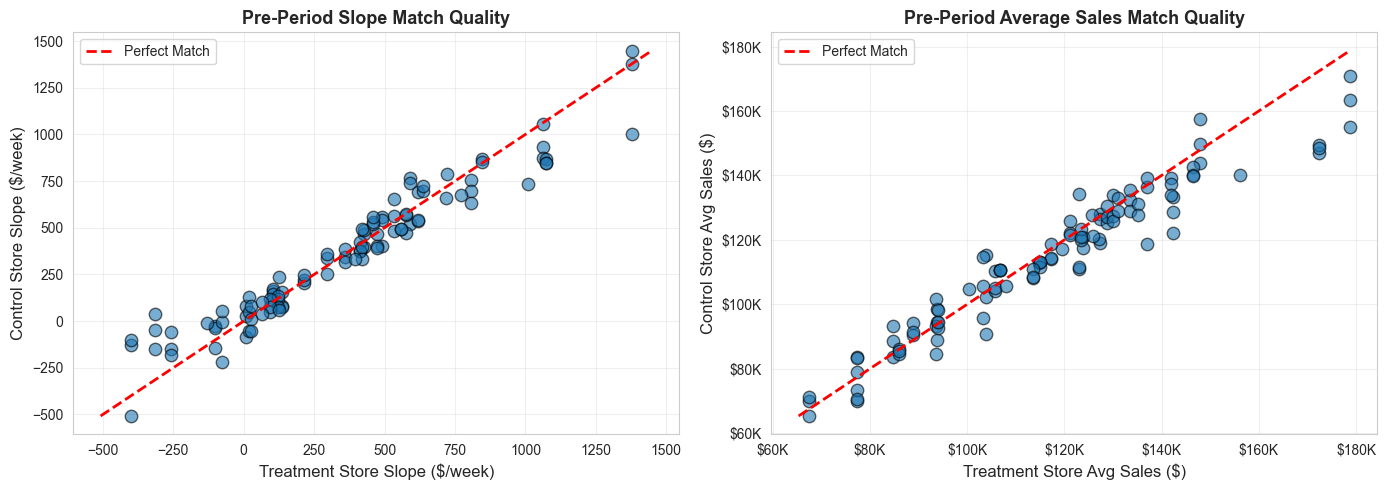


Note: Points closer to the red diagonal line indicate better matches


In [8]:
# Plot matched pairs in feature space
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Slope comparison
ax = axes[0]
ax.scatter(matched_df['pre_slope_treatment'], matched_df['pre_slope_control'], 
          alpha=0.6, s=80, edgecolor='black')
# Add diagonal line (perfect match)
min_slope = min(matched_df['pre_slope_treatment'].min(), matched_df['pre_slope_control'].min())
max_slope = max(matched_df['pre_slope_treatment'].max(), matched_df['pre_slope_control'].max())
ax.plot([min_slope, max_slope], [min_slope, max_slope], 'r--', linewidth=2, label='Perfect Match')
ax.set_xlabel('Treatment Store Slope ($/week)', fontsize=12)
ax.set_ylabel('Control Store Slope ($/week)', fontsize=12)
ax.set_title('Pre-Period Slope Match Quality', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Average sales comparison
ax = axes[1]
ax.scatter(matched_df['pre_avg_sales_treatment'], matched_df['pre_avg_sales_control'], 
          alpha=0.6, s=80, edgecolor='black')
# Add diagonal line (perfect match)
min_sales = min(matched_df['pre_avg_sales_treatment'].min(), matched_df['pre_avg_sales_control'].min())
max_sales = max(matched_df['pre_avg_sales_treatment'].max(), matched_df['pre_avg_sales_control'].max())
ax.plot([min_sales, max_sales], [min_sales, max_sales], 'r--', linewidth=2, label='Perfect Match')
ax.set_xlabel('Treatment Store Avg Sales ($)', fontsize=12)
ax.set_ylabel('Control Store Avg Sales ($)', fontsize=12)
ax.set_title('Pre-Period Average Sales Match Quality', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))

plt.tight_layout()
plt.show()

print("\nNote: Points closer to the red diagonal line indicate better matches")

## Balance Check

Compare treatment and matched control stores on all pre-period features.

In [9]:
# Calculate balance statistics
print("Balance Check: Treatment vs Matched Controls")
print("="*70)
print(f"{'Feature':<25} {'Treatment Mean':>15} {'Control Mean':>15} {'Difference':>10}")
print("-"*70)

for feature in ['pre_slope', 'pre_avg_sales', 'pre_sales_std']:
    treatment_mean = matched_df[f'{feature}_treatment'].mean()
    control_mean = matched_df[f'{feature}_control'].mean()
    diff = treatment_mean - control_mean
    
    print(f"{feature:<25} {treatment_mean:>15.2f} {control_mean:>15.2f} {diff:>10.2f}")

print("\nNote: Smaller differences indicate better balance after matching")

Balance Check: Treatment vs Matched Controls
Feature                    Treatment Mean    Control Mean Difference
----------------------------------------------------------------------
pre_slope                          352.67          355.53      -2.86
pre_avg_sales                   117367.56       114781.06    2586.51
pre_sales_std                    19785.27        18407.47    1377.80

Note: Smaller differences indicate better balance after matching


In [ ]:
# Create a side-by-side comparison of SMD before and after
fig, ax = plt.subplots(figsize=(10, 6))

features_labels = ['Slope', 'Avg Sales', 'Volatility']
x = np.arange(len(features_labels))
width = 0.35

smd_before_vals = [abs(smd_before['pre_slope']), abs(smd_before['pre_avg_sales']), abs(smd_before['pre_sales_std'])]
smd_after_vals = [abs(smd_after['pre_slope']), abs(smd_after['pre_avg_sales']), abs(smd_after['pre_sales_std'])]

bars1 = ax.bar(x - width/2, smd_before_vals, width, label='Before Matching', 
               color='coral', edgecolor='black', alpha=0.8)
bars2 = ax.bar(x + width/2, smd_after_vals, width, label='After Matching', 
               color='lightgreen', edgecolor='black', alpha=0.8)

# Add threshold lines
ax.axhline(y=0.1, color='green', linestyle='--', linewidth=2, label='Good Balance (SMD < 0.1)', alpha=0.7)
ax.axhline(y=0.2, color='orange', linestyle='--', linewidth=2, label='Acceptable (SMD < 0.2)', alpha=0.7)

ax.set_xlabel('Feature', fontsize=12, fontweight='bold')
ax.set_ylabel('Absolute Standardized Mean Difference', fontsize=12, fontweight='bold')
ax.set_title('Balance Improvement: Before vs After Matching', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(features_labels)
ax.legend(fontsize=10, loc='upper right')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../reports/figures/smd_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/smd_comparison.png")
print("\n" + "="*70)
print("MATCHING EFFECTIVENESS SUMMARY")
print("="*70)

for feature, label in zip(['pre_slope', 'pre_avg_sales', 'pre_sales_std'], features_labels):
    before = abs(smd_before[feature])
    after = abs(smd_after[feature])
    improvement = ((before - after) / before * 100) if before != 0 else 0
    
    print(f"\n{label}:")
    print(f"  SMD Before:  {before:.3f}")
    print(f"  SMD After:   {after:.3f}")
    print(f"  Improvement: {improvement:.1f}%")

In [ ]:
# Plot distributions after matching
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Pre-slope distribution
ax = axes[0, 0]
ax.hist(treatment_stores['pre_slope'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(matched_control_stores['pre_slope'], bins=20, alpha=0.6, label='Matched Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_slope'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(matched_control_stores['pre_slope'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Slope ($/week)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('AFTER Matching: Sales Slope Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.text(0.05, 0.95, f"SMD = {smd_after['pre_slope']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Plot 2: Pre-avg_sales distribution
ax = axes[0, 1]
ax.hist(treatment_stores['pre_avg_sales'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(matched_control_stores['pre_avg_sales'], bins=20, alpha=0.6, label='Matched Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_avg_sales'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(matched_control_stores['pre_avg_sales'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Average Sales ($)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('AFTER Matching: Average Sales Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.text(0.05, 0.95, f"SMD = {smd_after['pre_avg_sales']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Plot 3: Pre-sales_std distribution
ax = axes[1, 0]
ax.hist(treatment_stores['pre_sales_std'], bins=20, alpha=0.6, label='Treatment', 
        edgecolor='black', color='steelblue')
ax.hist(matched_control_stores['pre_sales_std'], bins=20, alpha=0.6, label='Matched Control', 
        edgecolor='black', color='coral')
ax.axvline(treatment_stores['pre_sales_std'].mean(), color='steelblue', 
           linestyle='--', linewidth=2, label='Treatment Mean')
ax.axvline(matched_control_stores['pre_sales_std'].mean(), color='coral', 
           linestyle='--', linewidth=2, label='Control Mean')
ax.set_xlabel('Pre-Period Sales Volatility ($)', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title('AFTER Matching: Sales Volatility Distribution', fontsize=12, fontweight='bold')
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3)
ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}K'))
ax.text(0.05, 0.95, f"SMD = {smd_after['pre_sales_std']:.3f}", 
        transform=ax.transAxes, fontsize=10, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Plot 4: Summary statistics table with improvement
ax = axes[1, 1]
ax.axis('off')
summary_data = []
for feature in ['pre_slope', 'pre_avg_sales', 'pre_sales_std']:
    improvement = ((abs(smd_before[feature]) - abs(smd_after[feature])) / abs(smd_before[feature]) * 100) if smd_before[feature] != 0 else 0
    summary_data.append([
        feature.replace('pre_', '').replace('_', ' ').title(),
        f"{smd_before[feature]:.3f}",
        f"{smd_after[feature]:.3f}",
        f"{improvement:.1f}%"
    ])

table = ax.table(cellText=summary_data,
                colLabels=['Feature', 'SMD Before', 'SMD After', 'Improvement'],
                cellLoc='center',
                loc='center',
                bbox=[0, 0.3, 1, 0.6])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4472C4')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax.set_title('Balance Improvement Summary', fontsize=12, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../reports/figures/balance_after_matching.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/balance_after_matching.png")

In [ ]:
# Get matched control stores (unique set)
matched_control_stores = features_df[features_df['store_id'].isin(unique_controls_used)].copy()

# Compute SMD after matching
print("Standardized Mean Differences (SMD) - AFTER Matching")
print("="*70)
print(f"{'Feature':<25} {'SMD':>10} {'Balance Assessment':>25}")
print("-"*70)

smd_after = {}
for feature in ['pre_slope', 'pre_avg_sales', 'pre_sales_std']:
    treatment_vals = treatment_stores[feature].values
    control_vals = matched_control_stores[feature].values
    
    smd = compute_standardized_mean_difference(treatment_vals, control_vals)
    smd_after[feature] = smd
    
    # Assess balance
    if abs(smd) < 0.1:
        assessment = "✓ Good"
    elif abs(smd) < 0.2:
        assessment = "~ Acceptable"
    else:
        assessment = "✗ Imbalanced"
    
    print(f"{feature:<25} {smd:>10.3f} {assessment:>25}")

print("\nNote: |SMD| < 0.1 = Good, < 0.2 = Acceptable, > 0.2 = Imbalanced")

## Post-Matching Balance Assessment

After matching, verify that treatment and matched control stores have similar distributions.

In [ ]:
# Create pre-post comparison visualization
fig, ax = plt.subplots(figsize=(10, 6))

x = np.array([0, 1])
width = 0.35

# Treatment stores
treatment_means = [treatment_pre_mean/1000, treatment_post_mean/1000]
ax.plot(x, treatment_means, 'o-', linewidth=3, markersize=12, 
        color='steelblue', label='Treatment Stores (Matched)', alpha=0.8)

# Control stores
control_means = [control_pre_mean/1000, control_post_mean/1000]
ax.plot(x, control_means, 's--', linewidth=3, markersize=12, 
        color='coral', label='Control Stores (Matched)', alpha=0.8)

# Add value labels
for i, (t_val, c_val) in enumerate(zip(treatment_means, control_means)):
    ax.text(x[i], t_val, f'${t_val:.1f}K', ha='center', va='bottom', 
            fontsize=10, fontweight='bold', color='steelblue')
    ax.text(x[i], c_val, f'${c_val:.1f}K', ha='center', va='top', 
            fontsize=10, fontweight='bold', color='coral')

# Annotate changes
mid_x = 0.5
mid_y_treatment = (treatment_means[0] + treatment_means[1]) / 2
mid_y_control = (control_means[0] + control_means[1]) / 2

ax.annotate('', xy=(1, treatment_means[1]), xytext=(0, treatment_means[0]),
            arrowprops=dict(arrowstyle='->', color='steelblue', lw=1.5, alpha=0.5))
ax.text(mid_x, mid_y_treatment + 3, f'+${treatment_change_mean/1000:.1f}K',
        ha='center', fontsize=9, color='steelblue', style='italic')

ax.annotate('', xy=(1, control_means[1]), xytext=(0, control_means[0]),
            arrowprops=dict(arrowstyle='->', color='coral', lw=1.5, alpha=0.5))
ax.text(mid_x, mid_y_control - 3, f'+${control_change_mean/1000:.1f}K',
        ha='center', fontsize=9, color='coral', style='italic')

ax.set_xticks(x)
ax.set_xticklabels(['Pre-Period\n(Weeks 1-52)', 'Post-Period\n(Weeks 53-104)'], fontsize=11)
ax.set_ylabel('Average Weekly Sales ($K)', fontsize=12, fontweight='bold')
ax.set_title('Matched DiD: Pre-Post Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='upper left')
ax.grid(True, alpha=0.3, axis='y')

# Add DiD annotation
ax.text(0.5, ax.get_ylim()[1] * 0.95, 
        f'DiD Effect = ${matched_did:,.0f} ({percent_lift:.2f}%)\n95% CI: [${ci_lower:,.0f}, ${ci_upper:,.0f}]',
        ha='center', va='top', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.7))

plt.tight_layout()
plt.savefig('../reports/figures/matched_did_pre_post.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/matched_did_pre_post.png")

### Pre-Post Comparison for Matched Stores

In [ ]:
# Plot bootstrap distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Bootstrap distribution of DiD estimates
ax = axes[0]
ax.hist(bootstrap_dist, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(did_est, color='red', linestyle='-', linewidth=2.5, label=f'Point Estimate = ${did_est:,.0f}')
ax.axvline(ci_lower, color='orange', linestyle='--', linewidth=2, label=f'95% CI Lower = ${ci_lower:,.0f}')
ax.axvline(ci_upper, color='orange', linestyle='--', linewidth=2, label=f'95% CI Upper = ${ci_upper:,.0f}')
ax.set_xlabel('DiD Treatment Effect ($)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Bootstrap Distribution of Matched DiD Estimate', fontsize=13, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

# Plot 2: Treatment effect with confidence interval
ax = axes[1]
ax.barh([0], [percent_lift], height=0.5, color='steelblue', edgecolor='black', alpha=0.8)
error = [(percent_lift - (ci_lower/baseline)*100), ((ci_upper/baseline)*100 - percent_lift)]
ax.errorbar([percent_lift], [0], xerr=[[error[0]], [error[1]]], 
            fmt='none', ecolor='red', elinewidth=3, capsize=10, capthick=3)
ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax.set_xlabel('Treatment Effect (%)', fontsize=12, fontweight='bold')
ax.set_title('Matched DiD: Treatment Effect with 95% CI', fontsize=13, fontweight='bold')
ax.set_yticks([0])
ax.set_yticklabels(['Matched DiD'])
ax.grid(True, alpha=0.3, axis='x')
ax.set_xlim([0, max(percent_lift + error[1] + 2, 12)])

# Add value annotation
ax.text(percent_lift, 0.15, f'{percent_lift:.2f}%\n[{(ci_lower/baseline)*100:.2f}%, {(ci_upper/baseline)*100:.2f}%]',
        ha='center', va='bottom', fontsize=11, fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.savefig('../reports/figures/matched_did_bootstrap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved: reports/figures/matched_did_bootstrap.png")

### Visualize Bootstrap Distribution

In [ ]:
def bootstrap_matched_did(matched_df, n_iterations=1000, random_seed=42):
    """
    Bootstrap confidence intervals for matched DiD estimator.
    
    Resamples matched pairs with replacement and computes DiD for each iteration.
    
    Parameters:
    - matched_df: DataFrame with matched pairs and their sales data
    - n_iterations: Number of bootstrap iterations
    - random_seed: Random seed for reproducibility
    
    Returns:
    - did_estimate: Point estimate
    - ci_lower: 2.5th percentile (lower bound of 95% CI)
    - ci_upper: 97.5th percentile (upper bound of 95% CI)
    - bootstrap_estimates: Array of all bootstrap estimates
    """
    np.random.seed(random_seed)
    
    bootstrap_estimates = []
    n_pairs = len(matched_df)
    
    for i in range(n_iterations):
        # Resample matched pairs with replacement
        sample_indices = np.random.choice(n_pairs, size=n_pairs, replace=True)
        sample_df = matched_df.iloc[sample_indices]
        
        # Compute DiD for this bootstrap sample
        treatment_pre = sample_df['treatment_pre_sales'].mean()
        treatment_post = sample_df['treatment_post_sales'].mean()
        control_pre = sample_df['control_pre_sales'].mean()
        control_post = sample_df['control_post_sales'].mean()
        
        treatment_change = treatment_post - treatment_pre
        control_change = control_post - control_pre
        
        did = treatment_change - control_change
        bootstrap_estimates.append(did)
    
    bootstrap_estimates = np.array(bootstrap_estimates)
    
    # Compute point estimate and confidence intervals
    did_estimate = matched_did  # Use the original estimate
    ci_lower = np.percentile(bootstrap_estimates, 2.5)
    ci_upper = np.percentile(bootstrap_estimates, 97.5)
    
    return did_estimate, ci_lower, ci_upper, bootstrap_estimates

# Run bootstrap
print("Running bootstrap resampling (1000 iterations)...")
print("This may take a moment...")

did_est, ci_lower, ci_upper, bootstrap_dist = bootstrap_matched_did(
    matched_df, 
    n_iterations=1000, 
    random_seed=42
)

print(f"\n✓ Bootstrap complete!")
print(f"\n{'='*70}")
print(f"MATCHED DiD ESTIMATE WITH 95% CONFIDENCE INTERVAL")
print(f"{'='*70}")
print(f"\nTreatment Effect: ${did_est:,.2f}")
print(f"95% CI: [${ci_lower:,.2f}, ${ci_upper:,.2f}]")
print(f"\nPercent Lift: {percent_lift:.2f}%")
print(f"95% CI: [{(ci_lower/baseline)*100:.2f}%, {(ci_upper/baseline)*100:.2f}%]")
print(f"{'='*70}")

### Bootstrap Confidence Intervals

Use bootstrap resampling to estimate confidence intervals for the matched DiD estimator.

In [ ]:
# Aggregate statistics
treatment_pre_mean = matched_df['treatment_pre_sales'].mean()
treatment_post_mean = matched_df['treatment_post_sales'].mean()
control_pre_mean = matched_df['control_pre_sales'].mean()
control_post_mean = matched_df['control_post_sales'].mean()

treatment_change_mean = treatment_post_mean - treatment_pre_mean
control_change_mean = control_post_mean - control_pre_mean

# DiD estimate
matched_did = treatment_change_mean - control_change_mean

# Percent lift
baseline = treatment_pre_mean
percent_lift = (matched_did / baseline) * 100

print("="*70)
print("MATCHED DIFFERENCE-IN-DIFFERENCES RESULTS")
print("="*70)
print(f"\nTreatment Stores (Matched):")
print(f"  Pre-period avg:  ${treatment_pre_mean:,.2f}")
print(f"  Post-period avg: ${treatment_post_mean:,.2f}")
print(f"  Change:          ${treatment_change_mean:,.2f}")

print(f"\nControl Stores (Matched):")
print(f"  Pre-period avg:  ${control_pre_mean:,.2f}")
print(f"  Post-period avg: ${control_post_mean:,.2f}")
print(f"  Change:          ${control_change_mean:,.2f}")

print(f"\n{'='*70}")
print(f"DiD Treatment Effect: ${matched_did:,.2f}")
print(f"Percent Lift:         {percent_lift:.2f}%")
print(f"{'='*70}")

### Aggregate Matched DiD Estimate

Compute the average treatment effect across all matched pairs.

In [ ]:
# Compute pre-period and post-period sales for each store
def compute_period_sales(df, store_id, period='pre'):
    """Compute average sales for a store in a given period."""
    store_data = df[df['store_id'] == store_id]
    
    if period == 'pre':
        period_data = store_data[store_data['week'] <= 52]
    else:  # post
        period_data = store_data[store_data['week'] > 52]
    
    return period_data['sales'].mean()

# Calculate pre and post sales for all stores in matched pairs
print("Computing pre and post-period sales for matched pairs...")

matched_df['treatment_pre_sales'] = matched_df['treatment_id'].apply(
    lambda x: compute_period_sales(df, x, 'pre')
)
matched_df['treatment_post_sales'] = matched_df['treatment_id'].apply(
    lambda x: compute_period_sales(df, x, 'post')
)
matched_df['control_pre_sales'] = matched_df['control_id'].apply(
    lambda x: compute_period_sales(df, x, 'pre')
)
matched_df['control_post_sales'] = matched_df['control_id'].apply(
    lambda x: compute_period_sales(df, x, 'post')
)

# Compute changes for treatment and control
matched_df['treatment_change'] = matched_df['treatment_post_sales'] - matched_df['treatment_pre_sales']
matched_df['control_change'] = matched_df['control_post_sales'] - matched_df['control_pre_sales']

# Compute DiD for each matched pair
matched_df['did_estimate'] = matched_df['treatment_change'] - matched_df['control_change']

print(f"\n✓ Computed sales changes for {len(matched_df)} matched pairs")
print(f"\nFirst few pairs with DiD estimates:")
matched_df[['treatment_id', 'control_id', 'treatment_change', 'control_change', 'did_estimate']].head(10)

## Matched Difference-in-Differences Analysis

Now that we have matched treatment and control stores, we can estimate the treatment effect using DiD:

**DiD Formula:**
$$\text{Treatment Effect} = (\bar{Y}_{treatment,post} - \bar{Y}_{treatment,pre}) - (\bar{Y}_{control,post} - \bar{Y}_{control,pre})$$

Where:
- $\bar{Y}_{treatment,post}$ = Average post-period sales for treatment stores
- $\bar{Y}_{treatment,pre}$ = Average pre-period sales for treatment stores
- $\bar{Y}_{control,post}$ = Average post-period sales for matched control stores
- $\bar{Y}_{control,pre}$ = Average pre-period sales for matched control stores

**Advantages of Matched DiD:**
- Controls for time-invariant store differences
- Accounts for common time trends
- Improved balance reduces confounding from heterogeneous trends

## Save Matched Dataset

In [10]:
# Save matched pairs
output_path = '../data/matched_pairs.csv'
matched_df.to_csv(output_path, index=False)

# Also save the matches dictionary for easy lookup
import json
matches_json_path = '../data/treatment_control_matches.json'
with open(matches_json_path, 'w') as f:
    json.dump(matches, f, indent=2)

print(f"Saved matched pairs to: {output_path}")
print(f"Saved matches dictionary to: {matches_json_path}")
print(f"\n✓ Matching complete!")
print(f"\nNext steps:")
print("  1. Compute matched DiD estimates")
print("  2. Compare to unmatched analysis")
print("  3. Assess sensitivity to match quality")

Saved matched pairs to: ../data/matched_pairs.csv
Saved matches dictionary to: ../data/treatment_control_matches.json

✓ Matching complete!

Next steps:
  1. Compute matched DiD estimates
  2. Compare to unmatched analysis
  3. Assess sensitivity to match quality
